# **Label Prediction**


## Data Pre-processing

In [ ]:
import pandas as pd
import nltk
import re

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
df = pd.read_csv('calls_dataset.csv') # Replace 'your_dataset.csv' with the actual file name
text_column = 'text_snippet' # Replace with the name of the column containing text

In [ ]:
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize the text
    words = text.split()

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    # Join the words back into a string
    processed_text = ' '.join(words)

    return processed_text

In [ ]:
df["text_snippet"] = df["text_snippet"].apply(preprocess_text)

In [ ]:
df.to_csv('processed_calls_dataset.csv',index=False)

## Training Label Classification Model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
X = df['text_snippet']
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['labels'].str.split(', '))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80% train, 20% test

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

# Create a pipeline with TF-IDF vectorization and ClassifierChain
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', ClassifierChain(LogisticRegression()))
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'tfidf__max_features': [1000, 2000, 3000],  # Number of features to extract
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # Unigrams or unigrams + bigrams
    'classifier__base_estimator__C': [0.1, 1, 10],  # Regularization parameter
}

# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_micro') # Using 5-fold cross-validation

# Fit the model with the training data
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_


# Save the model to a file
joblib.dump(best_model, 'label_prediction_model.pkl')
# Save the MultiLabelBinarizer
joblib.dump(mlb, 'multilabel_binarizer.pkl')

['multilabel_binarizer.pkl']

### Train Accuracies

In [ ]:
from sklearn.metrics import classification_report

# Predict labels for the training set using the best model
y_train_pred = best_model.predict(X_train)

# Generate the classification report for the training set
train_report = classification_report(y_train, y_train_pred, output_dict=True, zero_division=0,target_names=mlb.classes_)

# Print the train report per label
for label, metrics in train_report.items():
    if label not in ['accuracy', 'macro avg', 'weighted avg']: # Exclude overall metrics
        print(f"Label: {label}")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall: {metrics['recall']:.4f}")
        print(f"  F1-score: {metrics['f1-score']:.4f}")
        print("-" * 20)

Label: Competition
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000
--------------------
Label: Objection
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000
--------------------
Label: Positive
  Precision: 0.9800
  Recall: 1.0000
  F1-score: 0.9899
--------------------
Label: Pricing Discussion
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000
--------------------
Label: Security
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000
--------------------
Label: micro avg
  Precision: 0.9970
  Recall: 1.0000
  F1-score: 0.9985
--------------------
Label: samples avg
  Precision: 0.9981
  Recall: 1.0000
  F1-score: 0.9989
--------------------


### Test Accuracies

In [ ]:
from sklearn.metrics import classification_report

# Predict labels for the test set using the best model
y_pred = best_model.predict(X_test)

# Now, generate the classification report
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0,target_names=mlb.classes_)

# Print the report per label
for label, metrics in report.items():
    if label not in ['accuracy', 'macro avg', 'weighted avg']: # Exclude overall metrics
        print(f"Label: {label}")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall: {metrics['recall']:.4f}")
        print(f"  F1-score: {metrics['f1-score']:.4f}")
        print("-" * 20)

Label: Competition
  Precision: 0.9444
  Recall: 0.9444
  F1-score: 0.9444
--------------------
Label: Objection
  Precision: 0.9333
  Recall: 0.9333
  F1-score: 0.9333
--------------------
Label: Positive
  Precision: 1.0000
  Recall: 0.9167
  F1-score: 0.9565
--------------------
Label: Pricing Discussion
  Precision: 0.9545
  Recall: 0.9545
  F1-score: 0.9545
--------------------
Label: Security
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000
--------------------
Label: micro avg
  Precision: 0.9625
  Recall: 0.9506
  F1-score: 0.9565
--------------------
Label: samples avg
  Precision: 0.9630
  Recall: 0.9667
  F1-score: 0.9644
--------------------


### Confusion Matrix and Co-label dependance Heatmap

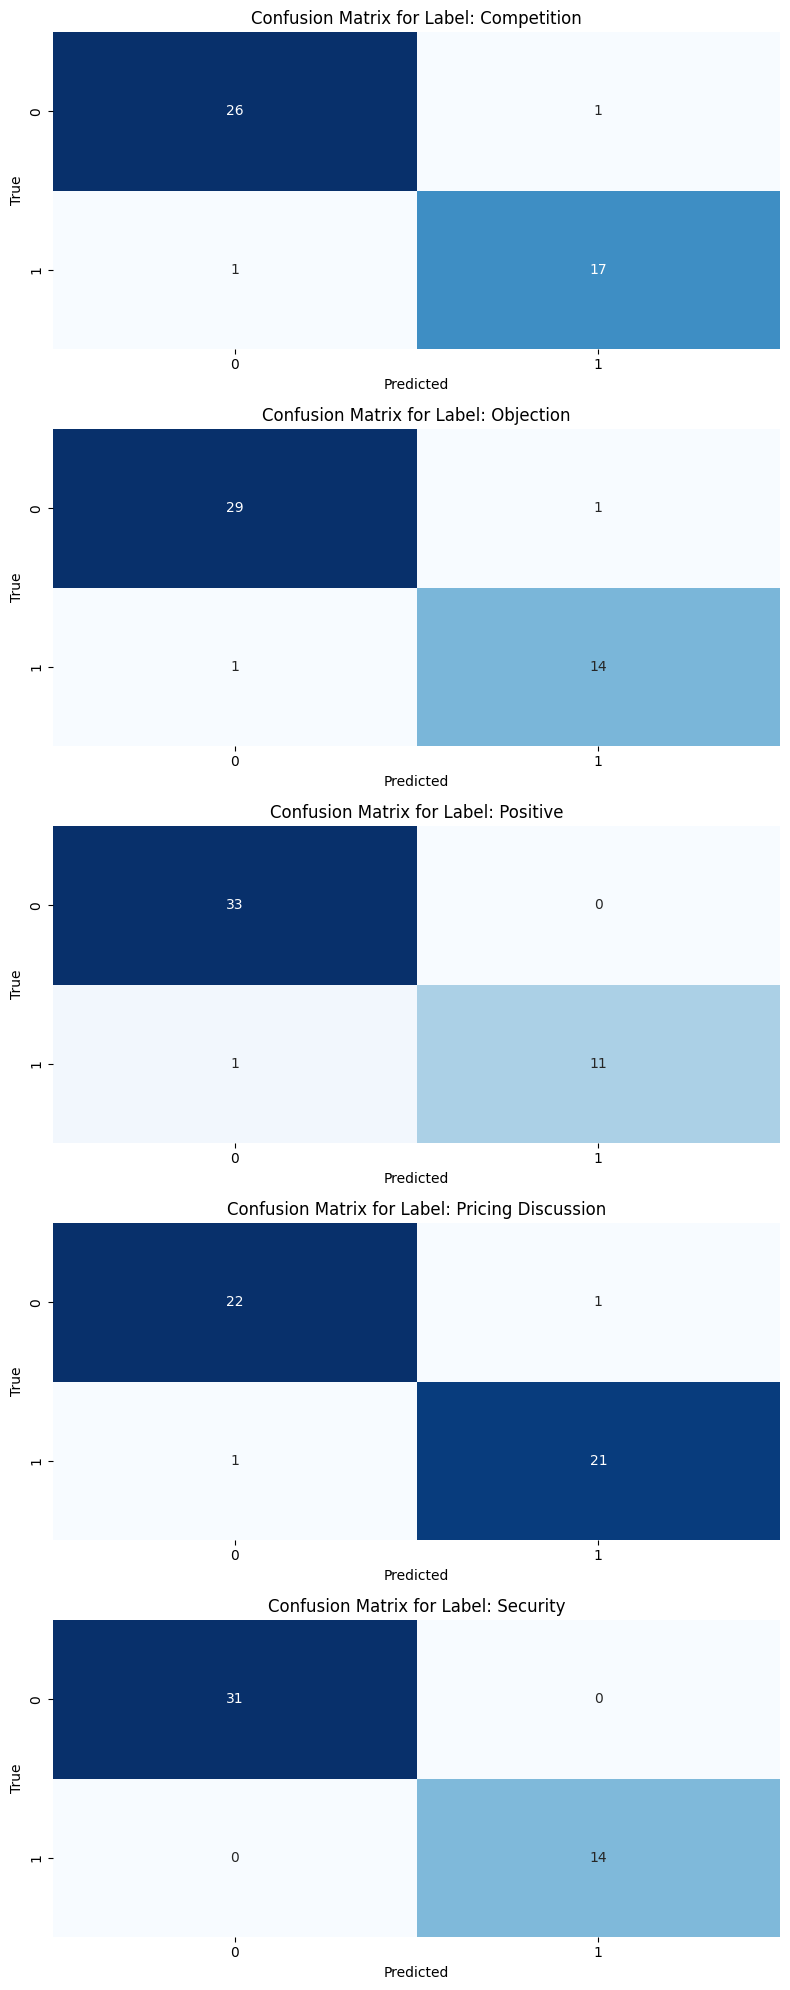

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix

# Assuming you have y_test and y_pred from the previous step

# Get the list of labels
labels = mlb.classes_

# Generate multilabel confusion matrix
conf_matrices = multilabel_confusion_matrix(y_test, y_pred)

# Plot confusion matrix for each label
fig, axes = plt.subplots(nrows=len(labels), ncols=1, figsize=(8, len(labels) * 4))
for i, (label, conf_matrix) in enumerate(zip(labels, conf_matrices)):
    ax = axes[i]
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_title(f"Confusion Matrix for Label: {label}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
plt.tight_layout()
plt.show()



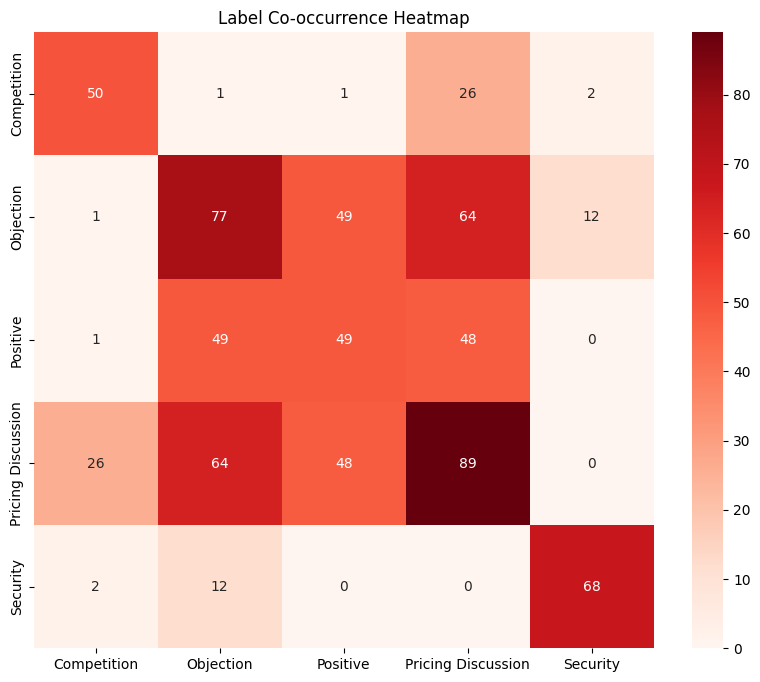

In [ ]:
# Heatmap of label co-occurrences
co_occurrence_matrix = np.dot(y_train.T, y_train)  # Use y_train for co-occurrences
plt.figure(figsize=(10, 8))
sns.heatmap(co_occurrence_matrix, annot=True, fmt="d", cmap="Reds", xticklabels=labels, yticklabels=labels)
plt.title("Label Co-occurrence Heatmap")
plt.show()

In [ ]:
misclassified_indices = np.where((y_test != y_pred).any(axis=1))[0]


misclassified_df = pd.DataFrame({
    'text_snippet': X_test.iloc[misclassified_indices],
    'true_labels': mlb.inverse_transform(y_test[misclassified_indices]),
    'predicted_labels': mlb.inverse_transform(y_pred[misclassified_indices])
})


misclassified_df.head()

,text_snippet,true_labels,predicted_labels
15,multilanguage support big plus subscription pl...,"(Objection, Positive, Pricing Discussion)","(Competition,)"
200,expanding north america need platform strong a...,"(Competition, Positive)","(Objection, Positive, Pricing Discussion)"
